In [101]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [102]:
# df = pd.read_csv('/content/drive/MyDrive/CSCI 214: Pattern Recognition/Labs/Lab2/dataset/all_stocks_2006-01-01_to_2018-01-01.csv')
df = pd.read_csv('./dataset/all_stocks_2006-01-01_to_2018-01-01.csv')
dim = 'Close'
df = df[df['Name']=='GOOGL'][['Date', dim]].reset_index(drop=True)
df.head()

,Date,Close
0,2006-01-03,217.83
1,2006-01-04,222.84
2,2006-01-05,225.85
3,2006-01-06,233.06
4,2006-01-09,233.68


# Regression: Vanilla

In [103]:
class TimeSeriesData(Dataset):
  def __init__(self, data, window_length, stride, num_outputs):
    self.data = data
    self.window_length = window_length
    self.stride = stride
    self.num_outputs = num_outputs
    self.num_samples = (len(data) - window_length - num_outputs) // stride + 1

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    start_idx = self.stride * idx
    x = self.data[start_idx: start_idx + self.window_length]
    y = self.data[start_idx + self.window_length: start_idx + self.window_length + self.num_outputs]
    return x, y



tensor([217.8300, 222.8400, 225.8500, 233.0600, 233.6800, 235.1100, 236.0500,
        232.0500, 233.3600, 233.7900, 222.6800, 218.4400, 199.9300, 213.9600,
        221.7400])
tensor([216.7200, 217.3500, 216.9600, 213.6200, 216.5500])


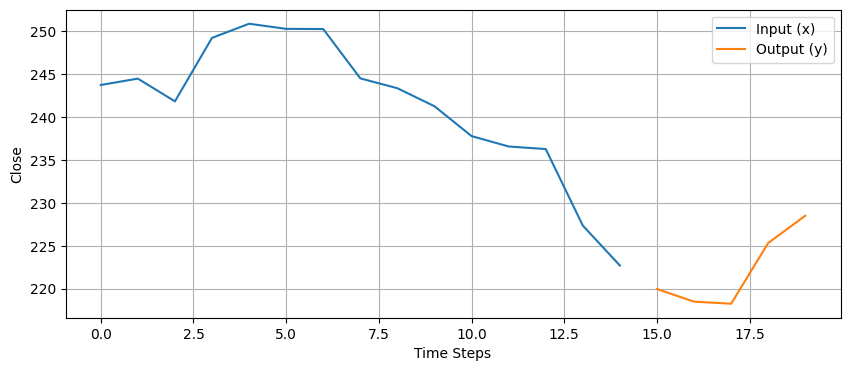

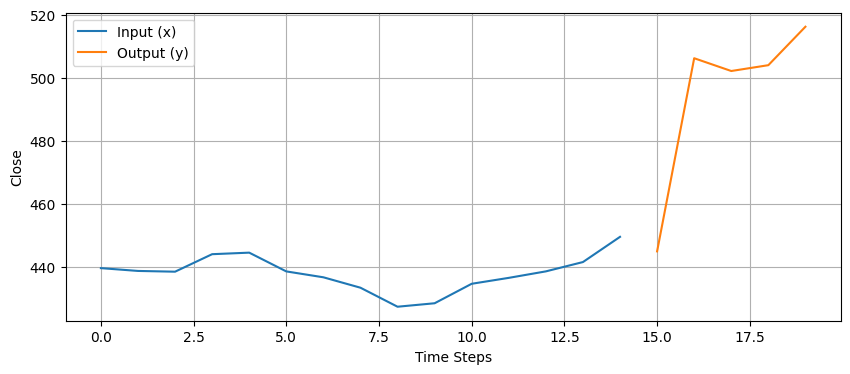

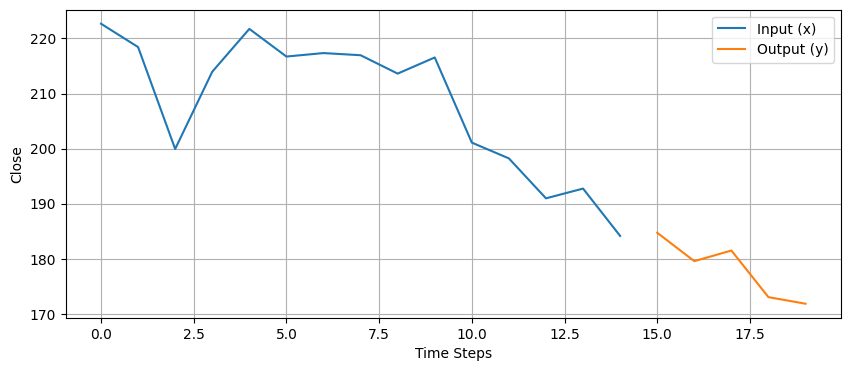

In [104]:
from random import randint
# property
window_length = 15
num_outputs = 5
stride = 5

data_tensor = torch.tensor(df[dim].values, dtype=torch.float32)
edge = int(0.7 * len(data_tensor))

train_tensor = data_tensor[:edge]
val_tensor = data_tensor[edge:]

train_data = TimeSeriesData(data=train_tensor, window_length=window_length, stride=stride, num_outputs=num_outputs)
val_data = TimeSeriesData(data=val_tensor, window_length=window_length, stride=stride, num_outputs=num_outputs)


# inspecting the dataset
sample_1_x, sample_1_y = train_data[0]
print(sample_1_x)
print(sample_1_y)

sample_indices = []
for _ in range(3):
  sample_indices.append(randint(0, train_data.num_samples))

for idx in sample_indices:
  x, y = train_data[idx]

  plt.figure(figsize=(10, 4))
  plt.plot(range(len(x)), x.cpu().numpy(), label="Input (x)")
  plt.plot(range(len(x), len(x) + len(y)), y.cpu().numpy(), label="Output (y)")
  plt.xlabel("Time Steps")
  plt.ylabel(dim)
  plt.legend()
  plt.grid(True)
  plt.show()


## Regression neural net
  - at least 2 hidden layers
  - no activation in the output layer

### Architecture
  - input layer = window_length
  - output layer = num_outputs
  - hidden layer 1 = 64
  - hidden layer 2 = 32
  - activation function = sigmoid

### Loss function: MSELoss

In [105]:
# helper functions
def train_fn(model, optimizer, loss_fn, train_loader, test_loader):
  model.train()

  ave_loss = 0.0

  for x, y in train_loader:
    predictions = model.forward(x)
    loss = loss_fn(predictions, y)

    ave_loss += loss.item()

    # optimize the weight
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  ave_loss = ave_loss / len(train_loader)

  val_loss = 0.0
  model.eval()

  for x, y in test_loader:
    predictions = model.forward(x)
    loss_ = loss_fn(predictions, y)

    val_loss += loss_.item()

  val_loss = val_loss / len(test_loader)

  return ave_loss, val_loss

class RegressionModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size

    self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, output_size)
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [106]:
# regression model
reg_model = RegressionModel(input_size=window_length, output_size=num_outputs)

# backward propagation properties
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(reg_model.parameters(), lr=0.0001)

# dataloader set up
batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [107]:
# Model training
epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
  ave_loss, val_loss = train_fn(model=reg_model, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_dataloader, test_loader=val_dataloader)
  train_losses.append(ave_loss)
  val_losses.append(val_loss)

  print(f'Epoch [{epoch+1}/{epochs}] train: {ave_loss} Val: {val_loss}')

Epoch [1/1000] train: 106781.71135602679 Val: 590098.3020833334
Epoch [2/1000] train: 104052.58231026786 Val: 575795.5260416666
Epoch [3/1000] train: 101543.37806919643 Val: 562037.3385416666
Epoch [4/1000] train: 99295.83258928571 Val: 550328.9114583334
Epoch [5/1000] train: 97291.3994140625 Val: 539294.9947916666
Epoch [6/1000] train: 95300.41978236607 Val: 528120.9010416666
Epoch [7/1000] train: 93232.35518973214 Val: 516388.515625
Epoch [8/1000] train: 91055.56584821429 Val: 504027.0208333333
Epoch [9/1000] train: 88762.15680803571 Val: 491005.8151041667
Epoch [10/1000] train: 86342.20968191964 Val: 477251.2708333333
Epoch [11/1000] train: 83784.28641183036 Val: 462716.2369791667
Epoch [12/1000] train: 81086.67075892857 Val: 447404.3515625
Epoch [13/1000] train: 78259.6357421875 Val: 431400.5963541667
Epoch [14/1000] train: 75314.00613839286 Val: 414740.8802083333
Epoch [15/1000] train: 72248.78306361607 Val: 397420.4140625
Epoch [16/1000] train: 69072.61579241071 Val: 379504.34114

## Plotting MSE Losses with each epochs

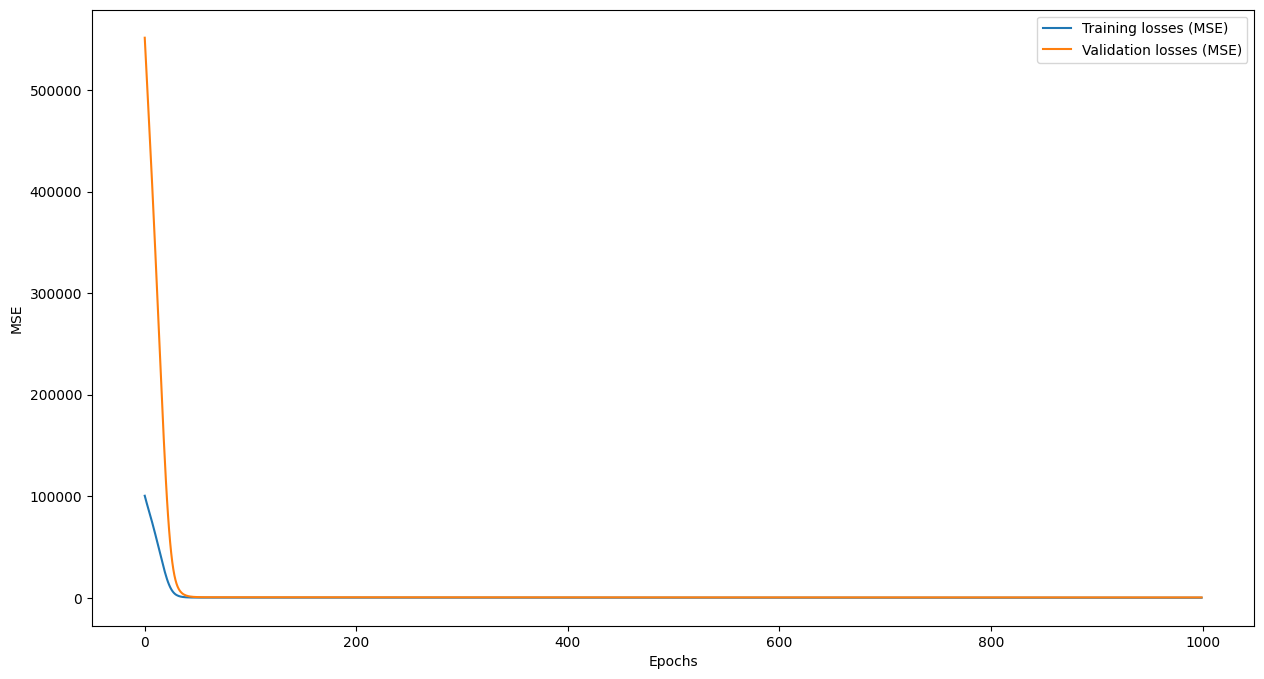

In [66]:
# Plotting the MSE Losses

plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs), train_losses, label='Training losses (MSE)')
plt.plot(np.arange(epochs), val_losses, label='Validation losses (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### simple design of converting predictions into a plottable sequence.
- to avoid overlapping of outputs, stride should be atleast equal to the number of outputs. in this case, stride = num_outputs. I designed it this way since I still got no idea how to handle overlapping outputs

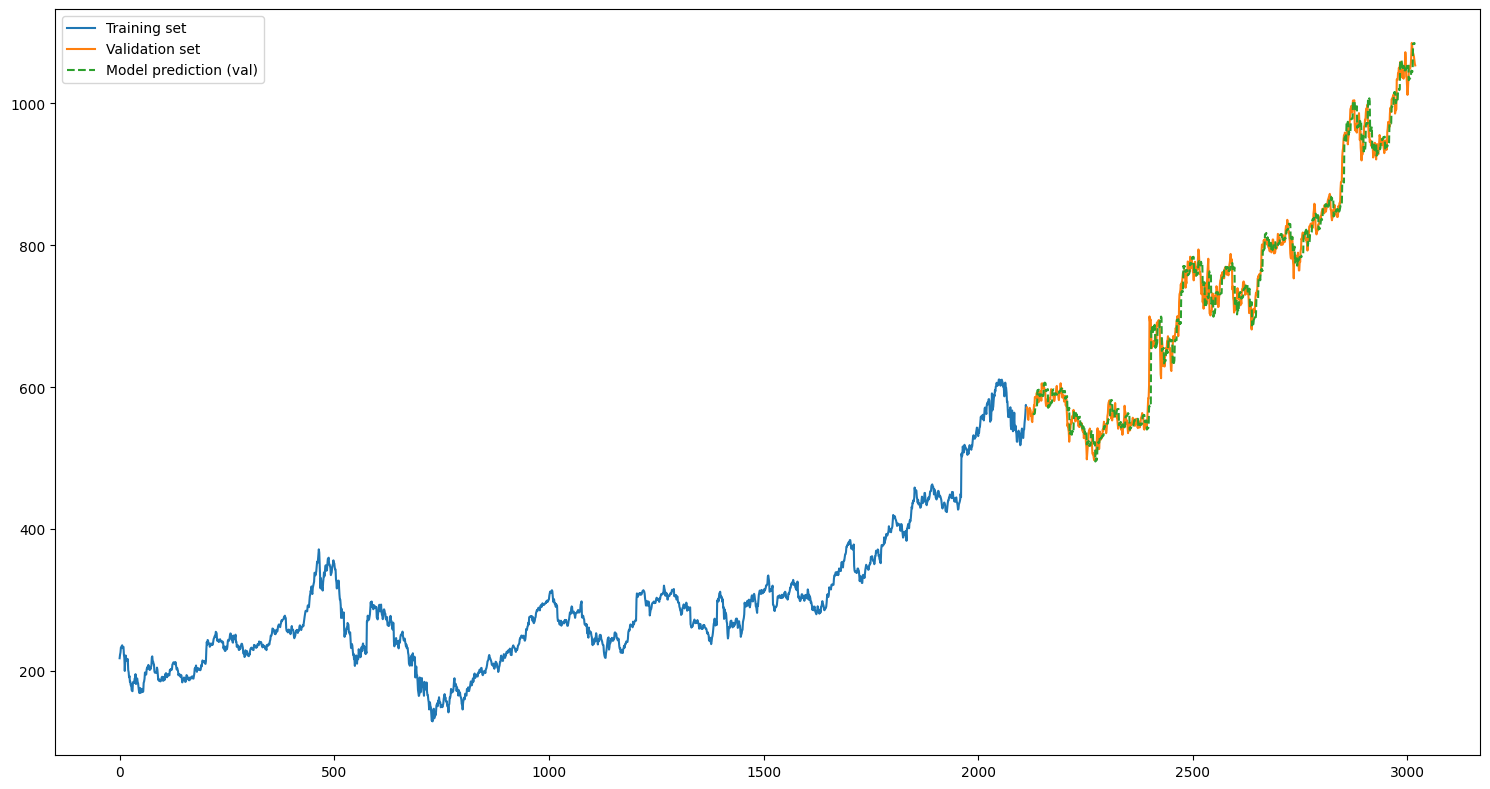

In [67]:
# simplest design, stride should be atleast equal to number of outputs.
# builds a 1D series with length = validation data. filled with model predictions or NaN if no prediction at a particular timestep
assert num_outputs == stride
def preds_to_series(model, dataloader, series_len, window_length, stride):
    model.eval()
    chunks = [] # -> storage for the model prediction. stores
    for X, _ in dataloader:
        X = X.float()
        chunks.append(model.forward(X).detach().numpy())   # shape of each chunks is [batch_size, num_outputs]
    model_out = np.concatenate(chunks, axis=0)             # [num_samples, num_outputs]
    num_samples, num_outputs = model_out.shape

    # helper index arrays
    i = np.arange(num_samples)[:, None] # window indices
    h = np.arange(num_outputs)[None, :] # corresponds to output indices

    idx = window_length + i * stride + h # shape [num_samples, num_outputs]
    flat_idx = idx.ravel()
    flat_val = model_out.ravel()

    out = np.full(series_len, np.nan, dtype=float)
    in_bounds = (flat_idx >= 0) & (flat_idx < series_len)
    out[flat_idx[in_bounds]] = flat_val[in_bounds]
    return out

val_pred_line = preds_to_series(
    reg_model, val_dataloader, series_len=len(val_tensor),
    window_length=window_length, stride=stride
)

# x-axes
x_train = np.arange(len(train_tensor))
x_val   = np.arange(len(train_tensor), len(train_tensor) + len(val_tensor))

# true values
train_np = train_tensor.detach().numpy().ravel()
val_np   = val_tensor.detach().numpy().ravel()

plt.figure(figsize=(15, 8))
plt.plot(x_train, train_np, label="Training set")
plt.plot(x_val, val_np, label="Validation set")
plt.plot(x_val, val_pred_line, linestyle="--", label="Model prediction (val)")
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# check the MAE for vanilla implementation
targets = val_tensor.detach().numpy().ravel()
targets = targets[~np.isnan(val_pred_line)]
predictions = val_pred_line[~np.isnan(val_pred_line)]
mse = np.sum((targets - predictions) ** 2) / len(targets)

print(f'Val MSE: {round(float(mse), 2)}')
print(f'Val RMSE: {round(float(mse) ** 0.5, 2)}')

Val MSE: 409.78
Val RMSE: 20.24


comparing RMSE to the values on validation data, I'd say that MSE and RMSE seems pretty reasonable values for the trained model. for better model evaluation, solve for R^2 value.

## Prediction of future steps, adding 2 methodology for noise

In [69]:
# Helper function
def future_plot(input_data, predicted_sequence):
  seq = predicted_sequence[len(input_data):]

  plt.figure(figsize=(14, 7))
  plt.plot(
      range(len(input_data)),
      input_data,
      label='Original data'
  )

  plt.plot(
      range(len(input_data), len(predicted_sequence)),
      seq,
      label="Predicted future"
  )
  plt.legend()
  plt.show()

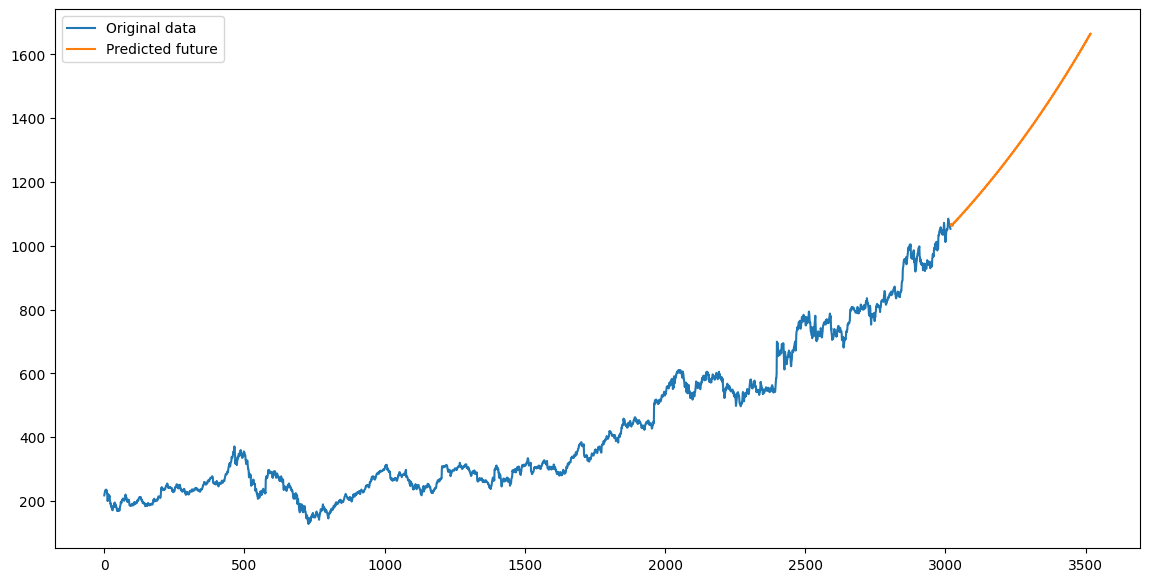

In [70]:
# Vanilla
future_steps = 100

reg_model.eval()
predicted_sequence = data_tensor.detach().tolist()

for _ in range(future_steps):
  input_sequence = torch.tensor(predicted_sequence[-window_length:], dtype=torch.float32)
  predicted_output = reg_model.forward(input_sequence)

  predicted_sequence.extend(predicted_output.tolist())

future_plot(data_tensor.tolist(), predicted_sequence)

## Evaluating the model through (1) plots, (2) evaluating the losses, (3) RMSE, (4) MSE

#### comparing RMSE to the values on validation data, I'd say that MSE and RMSE seems pretty reasonable values for the trained model. for better model evaluation, solve for R^2 value.

In [ ]:
# check the MAE for vanilla implementation
targets = val_tensor.detach().numpy().ravel()
targets = targets[~np.isnan(val_pred_line)]
predictions = val_pred_line[~np.isnan(val_pred_line)]
mse = np.sum((targets - predictions) ** 2) / len(targets)

print(f'Val MSE: {round(float(mse), 2)}')
print(f'Val RMSE: {round(float(mse) ** 0.5, 2)}')

Val MSE: 409.78
Val RMSE: 20.24


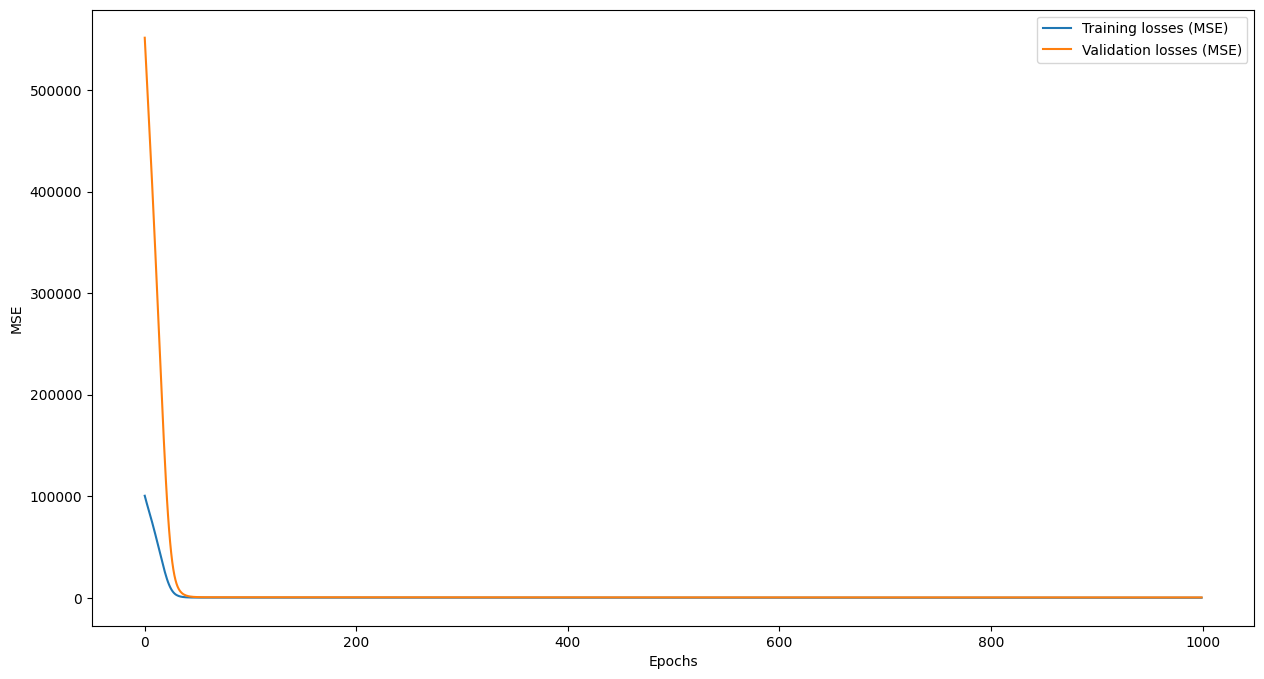

In [72]:
# Plotting the MSE Losses
plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs), train_losses, label='Training losses (MSE)')
plt.plot(np.arange(epochs), val_losses, label='Validation losses (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [73]:
# check the MAE for vanilla implementation
targets = val_tensor.detach().numpy().ravel()
targets = targets[~np.isnan(val_pred_line)]
predictions = val_pred_line[~np.isnan(val_pred_line)]
mse = np.sum((targets - predictions) ** 2) / len(targets)

print(f'Val MSE: {round(float(mse), 2)}')
print(f'Val RMSE: {round(float(mse) ** 0.5, 2)}')

Val MSE: 409.78
Val RMSE: 20.24


## Noise injection 1: Gaussian Noise Injection (GNI) in training
- I injected noise in the x during training as recommended by A comprehensive survey of deep learning for time series forecasting: architectural diversity and open challenges. It emphasized the importance of preserving the integrity of the target variable during training.
- Input preturbation is a safer and more common generalization strategy.

In [116]:
def add_input_noise(x, knob=0.01, scale=None):
    # optional feature-wise scaling
    if scale is None:
        noise = torch.randn_like(x) * knob
    else:
        noise = torch.randn_like(x) * knob * scale
    return x + noise

def noisy_train_fn(model, optimizer, loss_fn, train_loader, test_loader, knob):
    model.train()
    ave_loss = 0.0

    for x, y in train_loader:
        # optional: feature-wise std for scale-invariant noise
        # computes per-feature (or per-channel) std over the batch+time dims
        scale = x.std(dim=0, keepdim=True).clamp_min(1e-8)

        x_noisy = add_input_noise(x, knob, scale)

        # concat clean + noisy
        x_mix = torch.cat([x, x_noisy], dim=0)
        y_mix = torch.cat([y, y], dim=0)

        preds = model(x_mix)
        loss = loss_fn(preds, y_mix)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ave_loss += loss.item()

    ave_loss /= len(train_loader)

    # vanilla eval (no noise)
    model.eval()
    val_loss = 0.0
    for x, y in test_loader:
        preds = model(x)
        val_loss += loss_fn(preds, y).item()
    val_loss /= len(test_loader)
    return ave_loss, val_loss


In [119]:
noise1_reg_model = RegressionModel(input_size=window_length, output_size=num_outputs)
optimizer   = torch.optim.Adam(noise1_reg_model.parameters(), lr=0.0001)
loss_fn     = nn.MSELoss()

epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
  ave_loss, val_loss = noisy_train_fn(model=noise1_reg_model,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      train_loader=train_dataloader,
                                      test_loader=val_dataloader,
                                      knob=1)
  train_losses.append(ave_loss)
  val_losses.append(val_loss)

  print(f'Epoch [{epoch+1}/{epochs}] train: {ave_loss} Val: {val_loss}')

Epoch [1/1000] train: 118223.40345982143 Val: 648506.7291666666
Epoch [2/1000] train: 113430.03878348214 Val: 624263.359375
Epoch [3/1000] train: 109434.748046875 Val: 603391.6979166666
Epoch [4/1000] train: 105967.29045758929 Val: 583595.328125
Epoch [5/1000] train: 101993.49483816964 Val: 560601.2447916666
Epoch [6/1000] train: 97754.61537388393 Val: 536840.4739583334
Epoch [7/1000] train: 93425.03459821429 Val: 512327.3697916667
Epoch [8/1000] train: 88894.68624441964 Val: 486959.0625
Epoch [9/1000] train: 84233.64592633929 Val: 460599.3151041667
Epoch [10/1000] train: 79368.30524553571 Val: 433189.7994791667
Epoch [11/1000] train: 74332.1904296875 Val: 404775.4505208333
Epoch [12/1000] train: 69280.17145647321 Val: 376459.0963541667
Epoch [13/1000] train: 64189.5283203125 Val: 347801.0078125
Epoch [14/1000] train: 58939.6796875 Val: 318548.625
Epoch [15/1000] train: 53619.94105747768 Val: 288999.7447916667
Epoch [16/1000] train: 48337.955078125 Val: 259159.33333333334
Epoch [17/100

In [115]:
print("Metrics for the noisy regression model method 1: Gaussian noise injection in the training input")
print(f'Train MSE: {round(ave_loss, 2)}')
print(f'MSE: {round(val_loss, 2)}')
print(f'RMSE: {round(val_loss ** 0.5, 2)}')

Metrics for the noisy regression model method 1: Gaussian noise injection in the training input
Train MSE: 109.34
MSE: 415.24
RMSE: 20.38


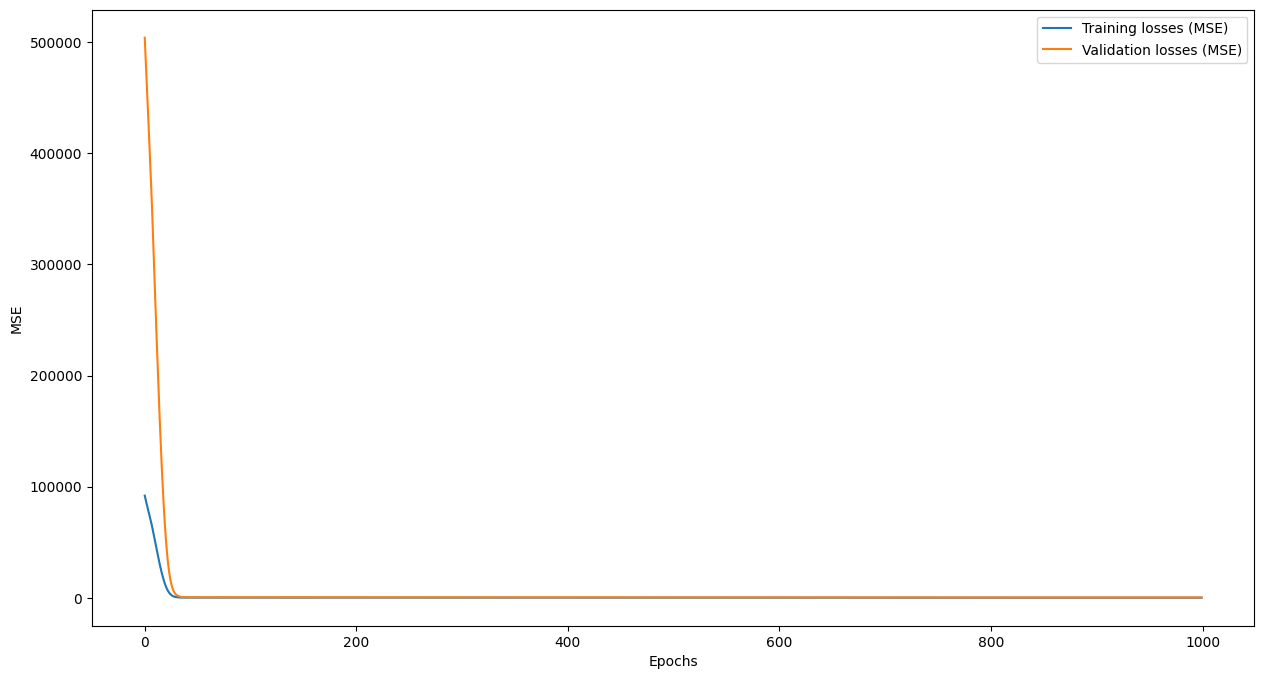

In [77]:
# Plotting the MSE Losses

plt.figure(figsize=(15, 8))
plt.plot(np.arange(epochs), train_losses, label='Training losses (MSE)')
plt.plot(np.arange(epochs), val_losses, label='Validation losses (MSE)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

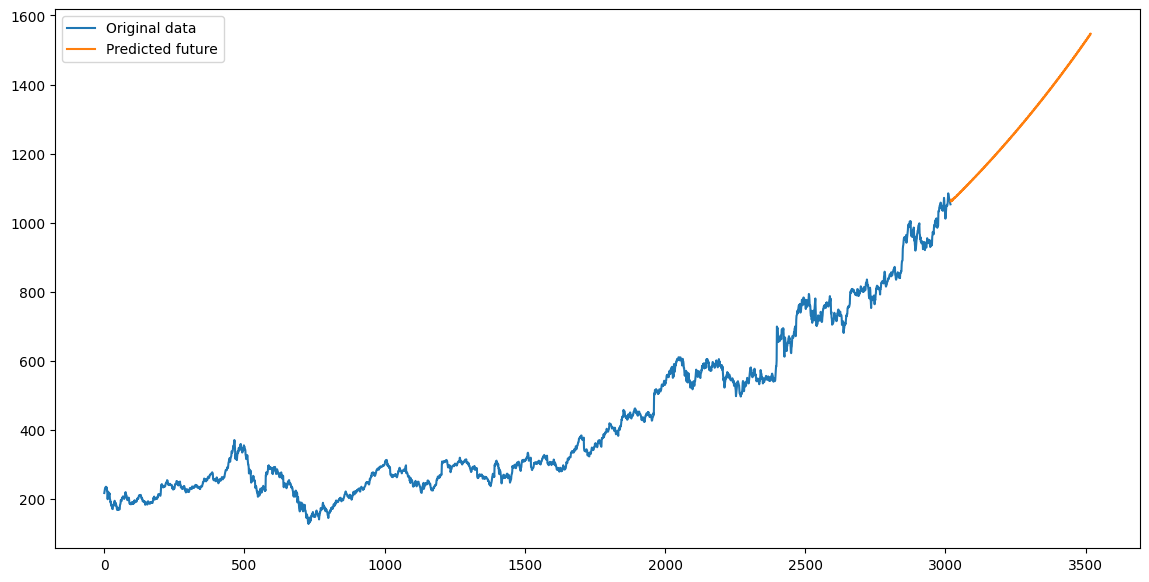

In [78]:
future_steps = 100

noise1_reg_model.eval()
predicted_sequence = data_tensor.detach().tolist()

for _ in range(future_steps):
  input_sequence = torch.tensor(predicted_sequence[-window_length:], dtype=torch.float32)
  predicted_output = noise1_reg_model.forward(input_sequence)

  predicted_sequence.extend(predicted_output.tolist())

future_plot(data_tensor.tolist(), predicted_sequence)

## Noise method 2: Prediction intervals from bootstrapped residuals
- forecast error is defined as e_t = y_t - y_t|t-1
- simulate the next observation of a time series using
y_t+1 = y_t+1|t + e_t+1
- assuming future errors will be similar to past errors, we can replace unknown future errors from the collection of errors we have seen in the past.
- my own spin on this method is to keep a FIXED residual storage from REAL DATA not from the recursive future steps.
- ONLY UPDATE residual storage when re-training for REAL DATA
https://otexts.com/fpp2/prediction-intervals.html

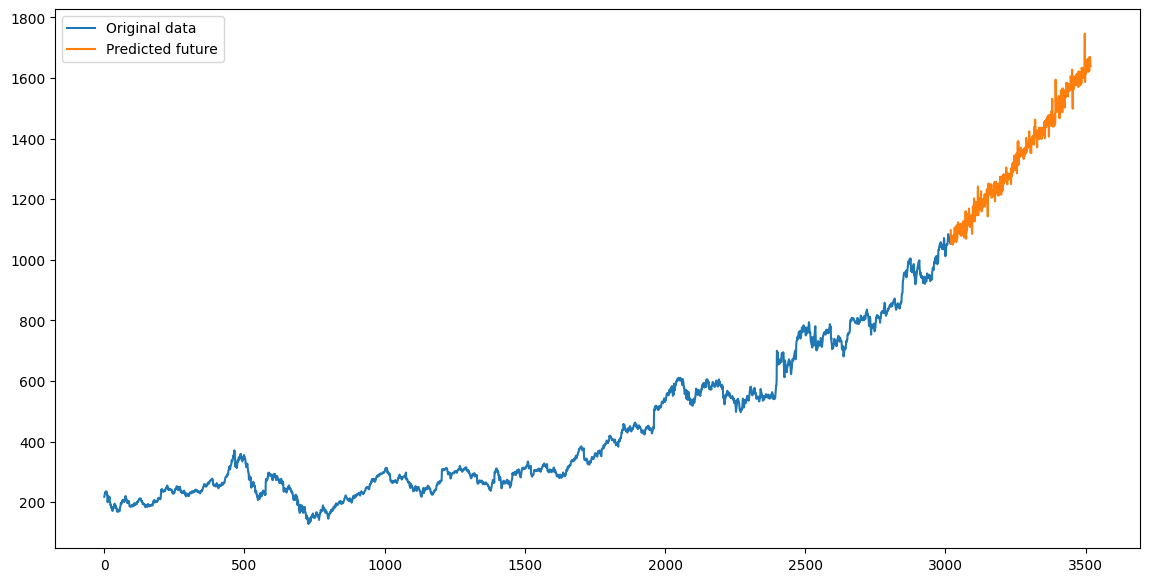

In [79]:
def residual_storage(model, val_loader):
  model.eval()
  res = []
  for x, y in val_loader:
    res.append(y - model.forward(x))

  res = torch.cat(res)
  res = res.reshape(-1)
  return res

res_storage = residual_storage(reg_model, val_dataloader)

def generate_noise(y, noise_storage, num_outputs):
  for i in range(num_outputs):
    idx = torch.randint(len(noise_storage), (1,)).item()
    y[i] = y[i] + noise_storage[idx]
  return y

future_steps = 100

reg_model.eval()
predicted_sequence = data_tensor.detach().tolist()

for _ in range(future_steps):
  input_sequence = torch.tensor(predicted_sequence[-window_length:], dtype=torch.float32)
  predicted_output = reg_model.forward(input_sequence)
  predicted_output = generate_noise(predicted_output, res_storage, num_outputs) # noise generating part
  predicted_sequence.extend(predicted_output.tolist())

future_plot(data_tensor.tolist(), predicted_sequence)  

# Guide question codes

### Effects of varying window_lengths and strides.

In [80]:
def train_fn(model, optimizer, loss_fn, train_loader, test_loader):
    model.train()

    ave_loss = 0.0

    for x, y in train_loader:
      predictions = model.forward(x)
      loss = loss_fn(predictions, y)

      ave_loss += loss.item()

      # optimize the weight
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    ave_loss = ave_loss / len(train_loader)

    val_loss = 0.0
    model.eval()

    for x, y in test_loader:
      predictions = model.forward(x)
      loss_ = loss_fn(predictions, y)

      val_loss += loss_.item()

    val_loss = val_loss / len(test_loader)

    return ave_loss, val_loss

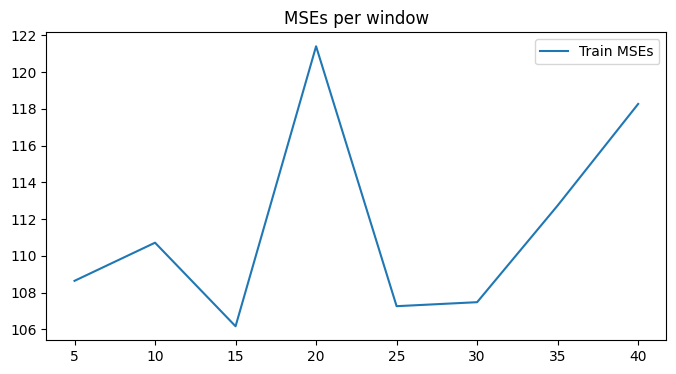

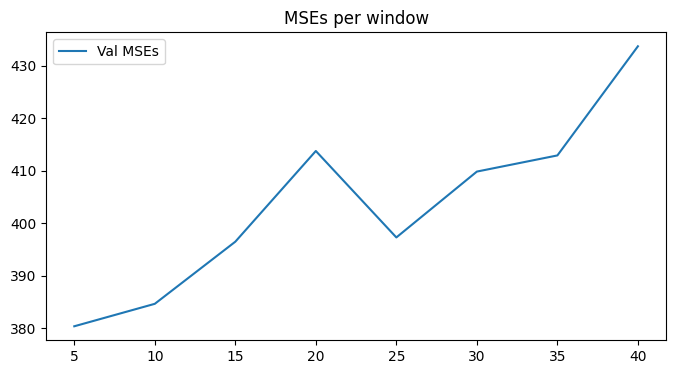

,window_lengths,train_MSEs,MSEs,RMSEs
0,5,108.639846,380.324023,19.501898
1,10,110.714482,384.604304,19.611331
2,15,106.167642,396.443568,19.910891
3,20,121.397722,413.729574,20.340343
4,25,107.260621,397.255798,19.931277
5,30,107.478058,409.805473,20.243653
6,35,112.736283,412.882350,20.319507
7,40,118.261267,433.683093,20.825059


In [81]:
window_lengths = [5, 10, 15, 20, 25, 30, 35, 40]
train_MSEs = []
MSEs = []
RMSEs = []

for window_length in window_lengths:
# window_length = 15
  num_outputs = 5
  stride = 5

  data_tensor = torch.tensor(df[dim].values, dtype=torch.float32)
  edge = int(0.7 * len(data_tensor))

  train_tensor = data_tensor[:edge]
  val_tensor = data_tensor[edge:]

  train_data = TimeSeriesData(data=train_tensor, window_length=window_length, stride=stride, num_outputs=num_outputs)
  val_data = TimeSeriesData(data=val_tensor, window_length=window_length, stride=stride, num_outputs=num_outputs)

  reg_model = RegressionModel(input_size=window_length, output_size=num_outputs)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(reg_model.parameters(), lr=0.0001)

  batch_size = 32

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

  epochs = 1000
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    ave_loss, val_loss = train_fn(model=reg_model, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_dataloader, test_loader=val_dataloader)
    train_losses.append(ave_loss)
    val_losses.append(val_loss)

  train_MSEs.append(train_losses[-1])
  MSEs.append(val_losses[-1])
  RMSEs.append(val_losses[-1] ** 0.5)

window_tests = pd.DataFrame(
  {
    'window_lengths': window_lengths,
    'train_MSEs': train_MSEs,
    'MSEs': MSEs,
    'RMSEs': RMSEs
  }
)

plt.figure(figsize=(8,4))
plt.plot(window_lengths, train_MSEs, label='Train MSEs')
plt.legend()
plt.title('MSEs per window')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(window_lengths, MSEs, label='Val MSEs')
plt.legend()
plt.title('MSEs per window')
plt.show()

window_tests

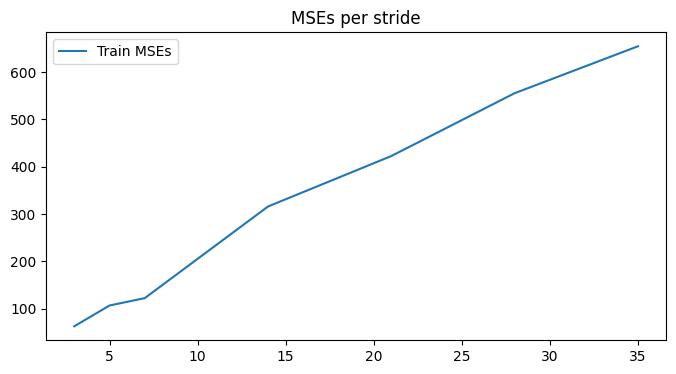

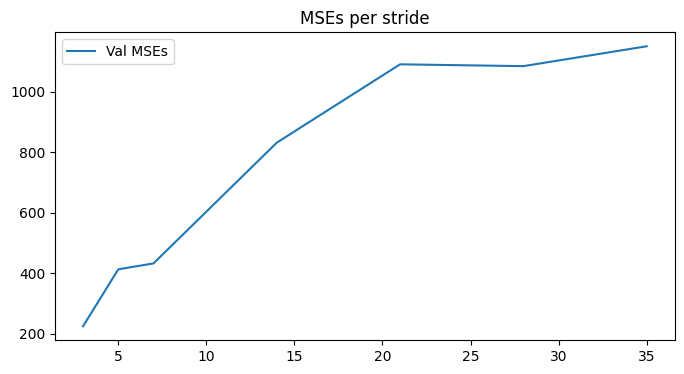

,Strides,Training MSEs,Val MSEs,Val RMSEs
0,3,62.666976,224.289020,14.976282
1,5,106.595961,412.489941,20.309848
2,7,122.157682,432.051254,20.785843
3,14,315.949969,831.117607,28.829110
4,21,422.676479,1090.049357,33.015896
5,28,555.502258,1084.013977,32.924368
6,35,654.740746,1149.681641,33.906956


In [84]:
strides = [3, 5, 7, 14, 21, 28, 35]
train_MSEs = []
MSEs = []
RMSEs = []

for stride in strides:
  window_length = 15
  num_outputs = stride
  # stride = 3

  data_tensor = torch.tensor(df[dim].values, dtype=torch.float32)
  edge = int(0.7 * len(data_tensor))

  train_tensor = data_tensor[:edge]
  val_tensor = data_tensor[edge:]

  train_data = TimeSeriesData(data=train_tensor, window_length=window_length, stride=stride, num_outputs=num_outputs)
  val_data = TimeSeriesData(data=val_tensor, window_length=window_length, stride=stride, num_outputs=num_outputs)

  reg_model = RegressionModel(input_size=window_length, output_size=num_outputs)
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(reg_model.parameters(), lr=0.0001)

  batch_size = 16

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
  val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

  epochs = 1000
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    ave_loss, val_loss = train_fn(model=reg_model, optimizer=optimizer, loss_fn=loss_fn, train_loader=train_dataloader, test_loader=val_dataloader)
    train_losses.append(ave_loss)
    val_losses.append(val_loss)

  MSEs.append(val_losses[-1])
  RMSEs.append(val_losses[-1] ** 0.5)
  train_MSEs.append(train_losses[-1])

stride_test = pd.DataFrame(
  {
    'Strides': strides,
    'Training MSEs': train_MSEs,
    'Val MSEs': MSEs,
    'Val RMSEs': RMSEs
  }
)

plt.figure(figsize=(8,4))
plt.plot(strides, train_MSEs, label='Train MSEs')
plt.legend()
plt.title('MSEs per stride')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(strides, MSEs, label='Val MSEs')
plt.legend()
plt.title('MSEs per stride')
plt.show()

stride_test